In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [ ]:
#!pip install qiskit ipywidgets # while working on google colab!

In [ ]:
# while working on google colab, run this cell
#!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils_2.py

In [2]:
from qbm_utils_2 import *

### Define the model

In [3]:
# define the model
np.random.seed(1)# should always be in the same cell!
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.randn(n_spins,n_spins), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
print("h is:", h)

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
print("alpha: ", alpha)

J after: [[ 0.     0.13  -0.105 -0.695]
 [ 0.13   0.     0.745 -0.57 ]
 [-0.105  0.745  0.    -0.465]
 [-0.695 -0.57  -0.465  0.   ]]
h is: [-0.17 -0.88  0.04  0.58]
alpha:  1.206396381047913


### Get the true distribution

In [4]:
def true_boltzman_distn(n_spins:int, temp:int, model, wanna_plot=False):

    states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
    # Actual_probability distribution
    transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in states_nbit ] )
    rqd_sum=np.sum(np.array(list(transits_bltz.values())))
    prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
    ### Prob distribution, sorted in descending order of prob values
    boltz_prob_distn=value_sorted_dict( dict(zip(states_nbit, prob_vals )), reverse=True )
    # plot distribution
    if wanna_plot:
        plt.figure(2)
    #plot_histogram([boltz_prob_distn], legend=["analytical"], sort="value_desc")
    plot_bargraph_desc_order(boltz_prob_distn, label="analytical",plot_first_few=20); plt.legend()
    return boltz_prob_distn

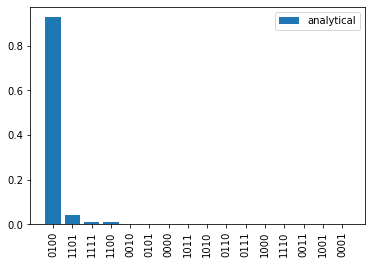

In [5]:
states_nbit=states(num_spins=n_spins)
temp=0.35
boltz_prob_distn=true_boltzman_distn(n_spins, temp=temp, model=model, wanna_plot=True)

In [6]:
mag_all_states=dict_magnetization_of_all_states(list_all_possible_states=states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=mag_all_states)
print("actual_avg_mag: ",actual_avg_mag)

actual_avg_mag:  -1.7277986852575642


### Function to run different number of chains of mcmc for a particular problem instance

In [32]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int,return_both=False, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    dict_seperate_chains_counts_based_on_hamming_dist={}
    dict_seperate_chains_energy_diff_s_and_sprime={}# for plotting histogram
    poss_states=list(range(0,num_elems))
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        init_state=np.random.choice(poss_states)
        poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                alpha,return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)
        else:
            dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =classical_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=cl_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=cl_mcmc_after_accept
        dict_seperate_chains_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept, model_in=model)
        dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept)

    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist


In [ ]:
# 10 seperate chains of classical mcmc for the given problem instance
N_hops=3000;num_seperate_mcmc_chains=10; return_last_n_states=N_hops
dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True )

100%|██████████| 1000/1000 [00:08<00:00, 115.78it/s]


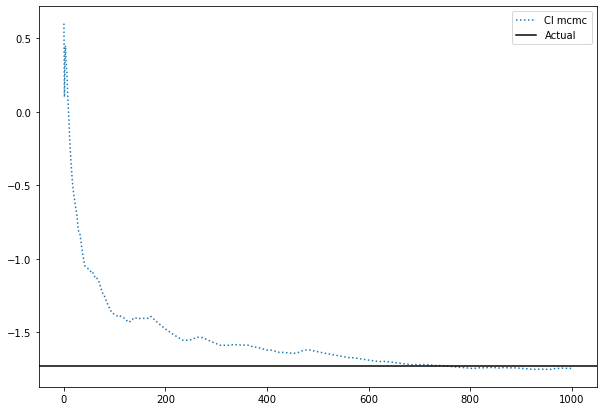

In [34]:
### data for plotting running average magnetization 5 cases seperately:
first_few=1000# 
#cl_running_avg_magzn=[running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc[m][:first_few+1]) for m in range(0,num_seperate_mcmc_chains)]
dict_for_df_running_avg_seperate_mcmc={}
for m in range(0, num_seperate_mcmc_chains):
  dict_for_df_running_avg_seperate_mcmc[m]=list(running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc[m][:first_few+1]).values())

running_avg_df=pd.DataFrame(dict_for_df_running_avg_seperate_mcmc)
mean_magnetization=running_avg_df.mean(axis=1)# mean taken over all seperate mcmc chains

plt.figure(figsize=(10,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.plot(mean_magnetization,":" ,label="Cl mcmc")
plt.axhline(y=actual_avg_mag,linestyle="-", color="k" ,label="Actual")
plt.legend()

In [35]:
# pandas data_frame for prob distn obtained from different mcmc chains
def fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_mcmc):
    df=pd.DataFrame(dict_seperate_chains_states_mcmc)
    df=df.fillna(0)
    return df

def get_dict_mean_occurences(df_seperate_chains_mcmc_states_occurences):
    mean_occurences=df_seperate_chains_mcmc_states_occurences.mean(axis=1)
    #print("mean occurences:"); print(mean_occurences)
    #print(f"type(mean_occurences): {type(mean_occurences)}")
    dict_mean_occurences=mean_occurences.to_dict()# mean number of occurences; we took mean of data obtained for mcmc chains
    # plt.figure(1); mean_occurences.plot.bar()
    return dict_mean_occurences

def get_empirical_distn(dict_mean_occurences):
    empirical_probs=list(np.array(list(dict_mean_occurences.values()))*(1./return_last_n_states))
    ### Prob distribution, sorted in descending order of prob values
    dict_empirical_prob_distn=dict(zip(list(dict_mean_occurences.keys()), empirical_probs ))
    return dict_empirical_prob_distn


## KL DIVERGENCE
def kl_divergence(dict_prob_distn_data,dict_prob_distn_model):
    ''' Borrowed from an old notebook''' 
    list_prob_model=list(dict_prob_distn_data.values())
    list_prob_data=list(dict_prob_distn_model.values())
    
    to_return=0
    for i in range(0,len(list_prob_model)):
        if(list_prob_data[i]== 0):
            to_return+= 0
        if(list_prob_model[i]!= 0):
            to_return+=list_prob_data[i]*np.log(list_prob_model[i]/list_prob_data[i])
    to_return=(-1)*to_return
    
    return to_return

<Figure size 432x288 with 0 Axes>

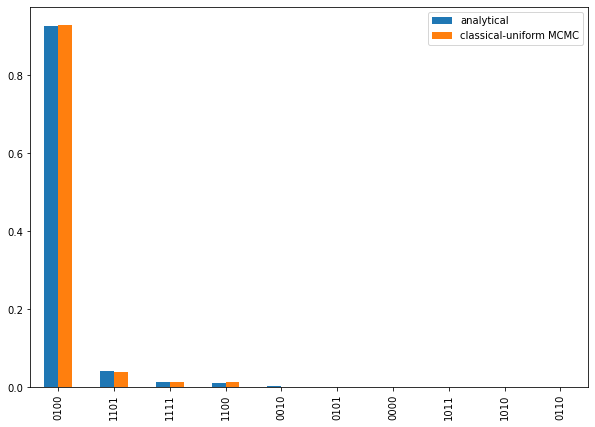

In [36]:
### for classical mcmc
df_1=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc)
dict_mean_occurences=get_dict_mean_occurences(df_1)
dict_empirical_cl_prob_distn=get_empirical_distn(dict_mean_occurences)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn],
                        list_labels=["analytical","classical-uniform MCMC"],
                        list_normalise=[False,False] ,plot_first_few=10,  
                        sort_desc=True,figsize=(10,7))

In [37]:
kl_divergence(dict_empirical_cl_prob_distn,boltz_prob_distn)

0.03701330615312842

### Quantum enhanced MCMC

In [ ]:
# 10 seperate chains of quantum mcmc for the given problem instance
N_hops=3000;num_seperate_mcmc_chains=10; return_last_n_states=N_hops
dict_seperate_chains_states_distn_mcmc_q, dict_seperate_chains_sprime_mcmc_q, dict_seperate_chains_accepted_mcmc_q, dict_seperate_chains_energy_diff_s_and_sprime_q,dict_seperate_chains_counts_based_on_hamming_dist_q=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True, is_quantum_mcmc=True, alpha=alpha )

In [ ]:
### data for plotting running average magnetization 5 cases seperately:
first_few=1000# 
#cl_running_avg_magzn=[running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc[m][:first_few+1]) for m in range(0,num_seperate_mcmc_chains)]
dict_for_df_running_avg_seperate_mcmc_q={}
for m in range(0, num_seperate_mcmc_chains):
  dict_for_df_running_avg_seperate_mcmc_q[m]=list(running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc_q[m][:first_few+1]).values())

running_avg_q_df=pd.DataFrame(dict_for_df_running_avg_seperate_mcmc_q)
mean_magnetization_q=running_avg_q_df.mean(axis=1)# mean taken over all seperate mcmc chains

plt.figure(figsize=(10,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.plot(mean_magnetization_q,":" ,label="Cl mcmc")
plt.axhline(y=actual_avg_mag,linestyle="-", color="k" ,label="Actual")
plt.legend()

In [ ]:
### for quantum mcmc
df_q=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc_q)
dict_mean_occurences_q=get_dict_mean_occurences(df_q)
dict_empirical_cl_prob_distn_q=get_empirical_distn(dict_mean_occurences_q)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn,dict_empirical_cl_prob_distn_q],
                        list_labels=["analytical","Cl-MCMC","Quant MCMC"],
                        list_normalise=[False,False,False] ,plot_first_few=10,  
                        sort_desc=True,figsize=(10,7))

In [ ]:
kl_divergence(dict_empirical_cl_prob_distn_q,boltz_prob_distn)